# EDS 220 Fall 2022
# Mapping and map projections with Google Earth Engine

Google Earth Engine is an extremely powerful tool for visualizing environmental data, making it an extremely popular choice in many contexts. However, the combination of Google Earth Engine with Cartopy is even more powerful, combining the on-the-fly ability of GEE to access and analyze data with Cartopy's strengths in map reprojection and generation of production-quality graphics.

To facilitate the use of Cartopy, we'll use the `cartoee` package. Cartoee functions as a 'go-between' for Earth Engine and Cartopy, by requesting images from Earth Engine and passing them through to Cartopy. In that way, the data can be reprojected as desired using Cartopy without the user having to download all the data from Earth Engine. Because of the utility of this approach, cartoee has been incorporated into `geemap` and can be called from that package such that it can be referred to on its own.

First, we import the relevant packages and initialize the Earth Engine environment:

In [1]:
# Import packages
import ee
import geemap
import pandas as pd
import cartopy
import cartopy.crs as ccrs
from geemap import cartoee
import matplotlib.pyplot as plt

In [2]:
# Authenticate and initialize GEE
#ee.Authenticate()
ee.Initialize()

Next, let's load some data. To get some variety from the Landsat examples we used in previous class sessions, let's pick a marine example!

The following example uses the _ocean color_ data collected by NASA's MODIS satellite:
https://developers.google.com/earth-engine/datasets/catalog/NASA_OCEANDATA_MODIS-Aqua_L3SMI#description

This product is derived from reflectance at the ocean surface in wavelength bands strongly affected by chlorophyll absorption; in this way, we can get an indication of how much photosynthesis by _phytoplankton_ (algae) is happening in the surface ocean.

Note that since ocean color is a derived product calculated from reflectance, it is considered a _Level 3_ data product (see description link above).

Let's load the set of MODIS data into a Google Earth Engine `ImageCollection`:

In [39]:
# Load the MODIS ocean color data
gdat = ee.ImageCollection("NASA/OCEANDATA/MODIS-Aqua/L3SMI")

The metadata for this image collection can be accessed through the Google Earth Engine web interface:
https://developers.google.com/earth-engine/datasets/catalog/NASA_OCEANDATA_MODIS-Aqua_L3SMI#bands

or we can get a sense for things by looking at a single image and using the `getInfo` function. To do the latter, we first need to select a single image (-not- an ImageCollection) to let us display that information. 

In [40]:
# Extract the first image in the MODIS image collection
firstimg=gdat.first()

# Display metadata for first MODIS image
firstimg.getInfo()

{'type': 'Image',
 'bands': [{'id': 'chlor_a',
   'data_type': {'type': 'PixelType', 'precision': 'float'},
   'dimensions': [8640, 4320],
   'crs': 'EPSG:4326',
   'crs_transform': [0.041666668, 0, -180, 0, -0.041666668, 90]},
  {'id': 'nflh',
   'data_type': {'type': 'PixelType', 'precision': 'float'},
   'dimensions': [8640, 4320],
   'crs': 'EPSG:4326',
   'crs_transform': [0.041666668, 0, -180, 0, -0.041666668, 90]},
  {'id': 'poc',
   'data_type': {'type': 'PixelType', 'precision': 'float'},
   'dimensions': [8640, 4320],
   'crs': 'EPSG:4326',
   'crs_transform': [0.041666668, 0, -180, 0, -0.041666668, 90]},
  {'id': 'Rrs_412',
   'data_type': {'type': 'PixelType', 'precision': 'float'},
   'dimensions': [8640, 4320],
   'crs': 'EPSG:4326',
   'crs_transform': [0.041666668, 0, -180, 0, -0.041666668, 90]},
  {'id': 'Rrs_443',
   'data_type': {'type': 'PixelType', 'precision': 'float'},
   'dimensions': [8640, 4320],
   'crs': 'EPSG:4326',
   'crs_transform': [0.041666668, 0, -180

As we did in the `Landsat_colormaps_GEE` notebook, it's desirable to reduce the size of the dataset in order to create something that can actually be plotted as a single map.

To accomplish this, let's do the following:
- get rid of cloudy days by filtering on the `CLOUD_COVER` attribute of the image collection;
- select a date range and take the time average over that range

In [41]:
# Use filter to extract all "non-cloudy" images: ones with less than 20% cloud cover
dat_nocld=gdat.filter('CLOUD_COVER < 0.2')

Now we need to figure out a relevant region to display. Here I've chosen one that gives us a sense of variability in chlorophyll through the __California Current__, which is our local current system off the Santa Barbara coast and a good example of a _western boundary current_. The California Current is an extremely _productive_ marine ecosystem because of the amount of _upwelling_ of cold subsurface ocean waters, making it rich in nutrients and therefore home to lots of different marine ecosystems.

To filter the image collection, we set up a central point using `ee.Geometry.Point`, and then define a `buffer` region around that point. Here I've chosen 1000km but you can change this if you like!

In [42]:
# Define the location of interest as a point near Los Angeles, California
u_lon = -118.2
u_lat = 34.05
u_poi = ee.Geometry.Point(u_lon, u_lat)

# Define the region: everything within 1000km of LA
roi = u_poi.buffer(1e6)

Once the region is defined, we can then use it to extract the portions of the image collection intersecting with that region, similar to what we did with Landsat for Santa Barbara. This can be accomplished using `filterBounds`, and providing the region object we created above as an argument:

In [43]:
# Filter to region of interest
dat_filt = dat_nocld.filterBounds(roi)

# Command to extract all data over appropriate time, perform temporal averaging
dat_2018=gdat.filter(ee.Filter.date('2018-6-1', '2018-12-31')).mean();

Now we have the data we need to plot! But we still have to supply some _visualization parameters_ in order to make everything display properly. Below I create an example of the data structure that Google Earth Engine needs to interpret these visualizations. 

Important parameters:
- the band name ("chlor_a") - note that there is only ONE band here, instead of the three we were using to create RGB images with Landsat information;
- minimum and maximum values to consider when assigning colors to the color bar later

In [46]:
# Visualization parameters
visParams = {'bands': ['chlor_a'],
             'min': 0,
             'max': 5,
            }

When the plot is generated, we can also use all of the functionality of Cartopy to set the plot parameters. Below, I've drawn in the coast outlines using `ax.coastlines()`, and used the `ax.gridlines` module to draw semitransparent gray dashed lat/lon grid lines:

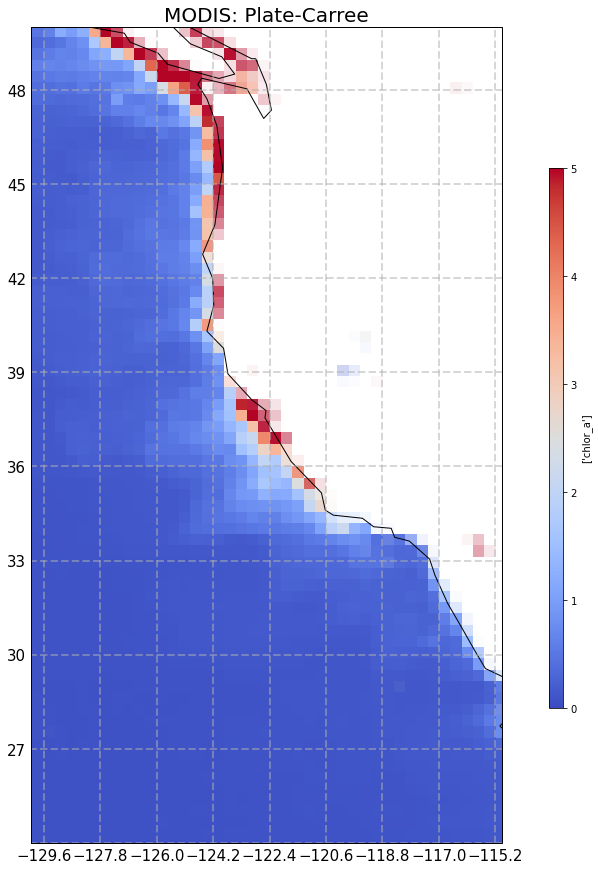

In [51]:
fig = plt.figure(figsize=(10, 15))

# create a new Plate-Carree projection 
projection = ccrs.PlateCarree()

# plot the result with cartoee 
ax = cartoee.get_map(dat_2018, vis_params=visParams, proj=projection, cmap='coolwarm')

# Define the lon/lat extent of the plot
ax.set_extent([-130,-115,24,50])   

# Draw in coastlines
ax.coastlines()

# Draw grid lines
gl=ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, alpha=0.5, linestyle='--')

# Set parameters for grid lines
gl.xlabels_top = False
gl.ylabels_right = False
gl.xlabel_style = {'size': 15}
gl.ylabel_style = {'size': 15}

# Set plot title
ax.set_title(label='MODIS: Plate-Carree', fontsize=20)

# Add color bar
cartoee.add_colorbar(ax,visParams,loc="right",cmap='coolwarm')

# Display plot
plt.show()

Now let's compare this with the visualization we'd have gotten if we used the interactive "base map" provided by Google Earth Engine. 

To do this, we need to specify a new set of visualization parameters, since we need another parameter called the color _palette_. The two codes in the palette correspond to the colors of the minimum and maximum values, and GEE will then assign colors ranging between the two specified values to all the data in between.

In [54]:
# Visualization parameters
visParams = {'bands': ['chlor_a'],
             'min': 0,
             'max': 5,
             'palette': ['0000FF', 'FF0000']
            }

Now we can draw the basemap and add the MODIS layer to it!

In [55]:
# Define parameters for GEE base map
Map = geemap.Map(center=[34.42, -124], zoom=6)

# Draw map
Map

Map(center=[34.42, -124], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=HBox(children…

In [56]:
# Add layer to the basemap
Map.addLayer(dat_2018, visParams)